In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from google.colab.patches import cv2_imshow


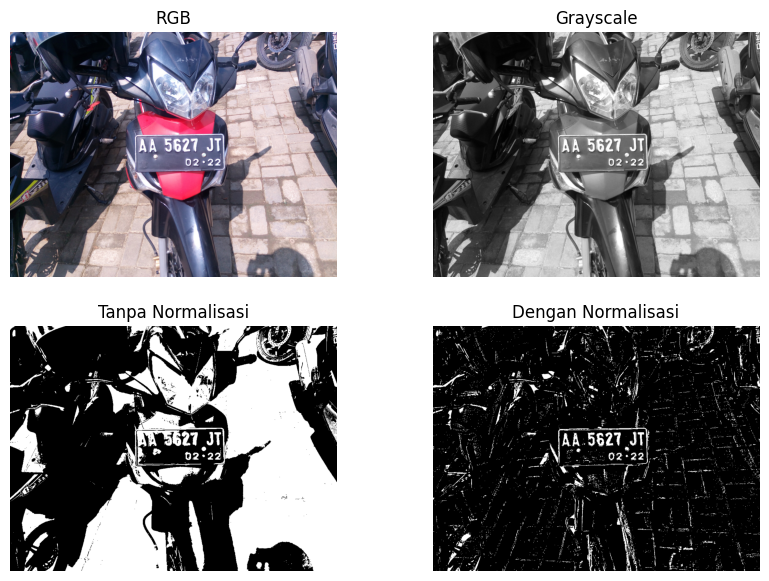

In [4]:
#---------------------------------------------------------------
# █▀▀█ █▀▀█ █▀▀█ █▀▀█ █▀▀ █▀▀▄ █▀▀▀ █▀▀█ █░░ █▀▀█ █░░█ █▀▀█ █▀▀▄
# █░░█ █▄▄▀ █▄▄█ █░░█ █▀▀ █░░█ █░▀█ █░░█ █░░ █▄▄█ █▀▀█ █▄▄█ █░░█
# █▀▀▀ ▀░▀▀ ▀░░▀ █▀▀▀ ▀▀▀ ▀░░▀ ▀▀▀▀ ▀▀▀▀ ▀▀▀ ▀░░▀ ▀░░▀ ▀░░▀ ▀░░▀
#---------------------------------------------------------------

# extract test_images.zip sampe data
import zipfile
with zipfile.ZipFile("/content/test_images.zip","r") as zip_ref:
    zip_ref.extractall("/content/")


# load citra RGB (BGR)
img_path = r'/content/test_images/AA5627JT.jpg'  # Replace with the correct path
img = cv.imread(img_path)

if img is None:
    print(f"Error: Could not load image from {img_path}. Check the file path and ensure the image exists.")
else:
    # resize citra dengan mengalikannya ukuran aslinya dengan 0.4
    # contoh: 1920 x 2560 ==> 1920 x 0.4 = 768 ; 2560 x 0.4 = 1024 ==> hasilnya 768 x 1024
    # img.shape[1] = kolom/lebar ; img.shape[0] = baris/tinggi
    # Hitung ukuran baru dengan faktor skala 0.4
    scale_factor = 0.4
    new_width = int(img.shape[1] * scale_factor)  # img.shape[1] = width
    new_height = int(img.shape[0] * scale_factor) # img.shape[0] = height
    new_size = (new_width, new_height)
    img_resized = cv.resize(img, new_size, interpolation=cv.INTER_AREA)
    img_rgb = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB) # convert bgr to rgb
    #img = cv.resize(img, (int(img.shape[1]*.4),int(img.shape[0]*.4)))

    # konversi dari BGR ke grayscale
    img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY) # convert bgr to grayscale

# Normalisasi Cahaya
# citra kendaraan memiliki intensitas cahaya yang berbeda-beda maka normalkan terlebih dahulu
# cara menormalkan intensitas cahaya:
# 1. lakukan operasi opening di citra gray
# 2. lakukan pengurangan citra gray dengan citra hasil opening
# 3. citra hasil normalisasi bisa diubah ke citra BW (hitam putih) dengan pengambangan Otsu

# buat kernel dengan bentuk ellipse, diameter 20 piksel
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20))

# Normalisasi cahaya (1)
# lakukan operasi opening ke citra grayscale dengan kernel yang sudah dibuat (var: kernel)
img_opening = cv.morphologyEx(img_gray, cv.MORPH_OPEN, kernel)

# Normalisasi cahaya (2)
# lakukan pengurangan citra grayscale dengan citra hasil opening
img_norm = img_gray - img_opening

# Normalisasi cahaya (3)
# konversi citra hasil normalisasi ke citra BW (hitam putih)
(thresh, img_norm_bw) = cv.threshold(img_norm, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# ==== Cek normalisasi START ====
# Untuk ngecek hasil sebelum dan sesudah dilakukan normalisasi
# Bisa di comment/uncomment

# buat citra bw tanpa normalisasi
(thresh, img_without_norm_bw) = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

fig = plt.figure(figsize=(10, 7))
row_fig = 2
column_fig = 2

fig.add_subplot(row_fig, column_fig, 1)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("RGB")

fig.add_subplot(row_fig, column_fig, 2)
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title("Grayscale")

fig.add_subplot(row_fig, column_fig, 3)
plt.imshow(img_without_norm_bw, cmap='gray')
plt.axis('off')
plt.title("Tanpa Normalisasi")

fig.add_subplot(row_fig, column_fig, 4)
plt.imshow(img_norm_bw, cmap='gray')
plt.axis('off')
plt.title("Dengan Normalisasi")

plt.show()

# ==== Cek normalisasi FINISH ====

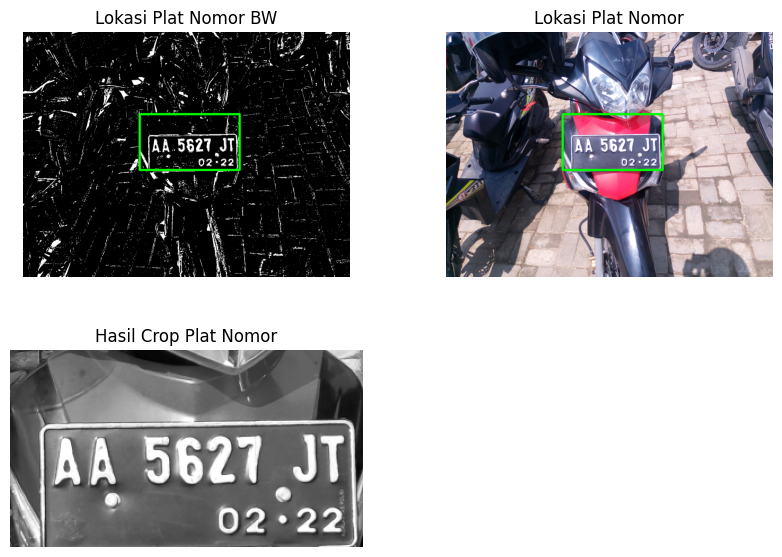

In [5]:
#------------------------------------------------------
# █▀▀▄ █▀▀ ▀▀█▀▀ █▀▀ █░█ █▀▀ ░▀░ 　 █▀▀█ █░░ █▀▀█ ▀▀█▀▀
# █░░█ █▀▀ ░░█░░ █▀▀ █▀▄ ▀▀█ ▀█▀ 　 █░░█ █░░ █▄▄█ ░░█░░
# ▀▀▀░ ▀▀▀ ░░▀░░ ▀▀▀ ▀░▀ ▀▀▀ ▀▀▀ 　 █▀▀▀ ▀▀▀ ▀░░▀ ░░▀░░
#------------------------------------------------------

# Deteksi plat menggunakan contours

# dapatkan contours dari citra kendaraan
contours_vehicle, hierarchy = cv.findContours(img_norm_bw, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) # get the contour for every area

# cek jumlah contours
# print(len(contours))

# index contour yang berisi kandidat plat nomor
index_plate_candidate = []

# index counter dari setiap contour di contours_vehichle
index_counter_contour_vehicle = 0

# filter setiap contour untuk mendapatkan kandidat plat nomor
for contour_vehicle in contours_vehicle:

    # dapatkan posisi x, y, nilai width, height, dari contour
    x,y,w,h = cv.boundingRect(contour_vehicle)

    # dapatkan nilai aspect rationya
    aspect_ratio = w/h

    # dapatkan kandidat plat nomornya apabila:
    # 1. lebar piksel lebih dari atau sama dengan 200 piksel
    # 2. aspect rationya kurang dari atau sama dengan 4
    if w >= 200 and aspect_ratio <= 4 :

        # dapatkan index kandidat plat nomornya
        index_plate_candidate.append(index_counter_contour_vehicle)

    # increment index counter dari contour
    index_counter_contour_vehicle += 1

# Dapatkan lokasi plat nomornya:
#   berdasarkan eksperimen, kita bisa mendapatkan satu atau dua lokasi plat
#   jika mendapatkan dua lokasi plat, berdasarkan observasi, pilih plat kedua karena ukurannya yang lebih pas
#

# buat duplikat citra RGB dan BW kendaraan untuk menampilkan lokasi plat
img_show_plate = img_resized.copy()
img_show_plate_bw = cv.cvtColor(img_norm_bw, cv.COLOR_GRAY2RGB)

if len(index_plate_candidate) == 0:

    # tampilkan peringatan plat nomor tidak terdeteksi
    print("Plat nomor tidak ditemukan")

# jika jumlah kandidat plat sama dengan 1
elif len(index_plate_candidate) == 1:

    # dapatkan lokasi untuk pemotongan citra plat
    x_plate,y_plate,w_plate,h_plate = cv.boundingRect(contours_vehicle[index_plate_candidate[0]])

    # gambar kotak lokasi plat nomor di citra RGB
    cv.rectangle(img_show_plate,(x_plate,y_plate),(x_plate+w_plate,y_plate+h_plate),(0,255,0),5)

    # gambar kotak lokasi plat nomor di citra BW
    cv.rectangle(img_show_plate_bw,(x_plate,y_plate),(x_plate+w_plate,y_plate+h_plate),(0,255,0),5)

    # crop citra plat
    img_plate_gray = img_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]
else:
    print('Dapat dua lokasi plat, pilih lokasi plat kedua')

    # dapatkan lokasi untuk pemotongan citra plat
    x_plate,y_plate,w_plate,h_plate = cv.boundingRect(contours_vehicle[index_plate_candidate[1]])

    # gambar kotak lokasi plat nomor di citra RGB
    cv.rectangle(img_show_plate,(x_plate,y_plate),(x_plate+w_plate,y_plate+h_plate),(0,255,0),5)

    # gambar kotak lokasi plat nomor di citra BW
    cv.rectangle(img_show_plate_bw,(x_plate,y_plate),(x_plate+w_plate,y_plate+h_plate),(0,255,0),5)

    # crop citra plat
    img_plate_gray = img_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]

# ==== Cek Deteksi Plat START ====
# Bisa di comment/uncomment

fig2 = plt.figure(figsize=(10, 7))
row_fig = 2
column_fig = 2

fig2.add_subplot(row_fig, column_fig, 1)
plt.imshow(cv.cvtColor(img_show_plate_bw, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Lokasi Plat Nomor BW")

fig2.add_subplot(row_fig, column_fig, 2)
plt.imshow(cv.cvtColor(img_show_plate, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Lokasi Plat Nomor")

fig2.add_subplot(row_fig, column_fig, 3)
plt.imshow(img_plate_gray, cmap="gray")
plt.axis('off')
plt.title("Hasil Crop Plat Nomor")

plt.show()

# ==== Cek Deteksi Plat FINISH ====

[7. 7. 7. 7. 7. 7. 7. 7.]


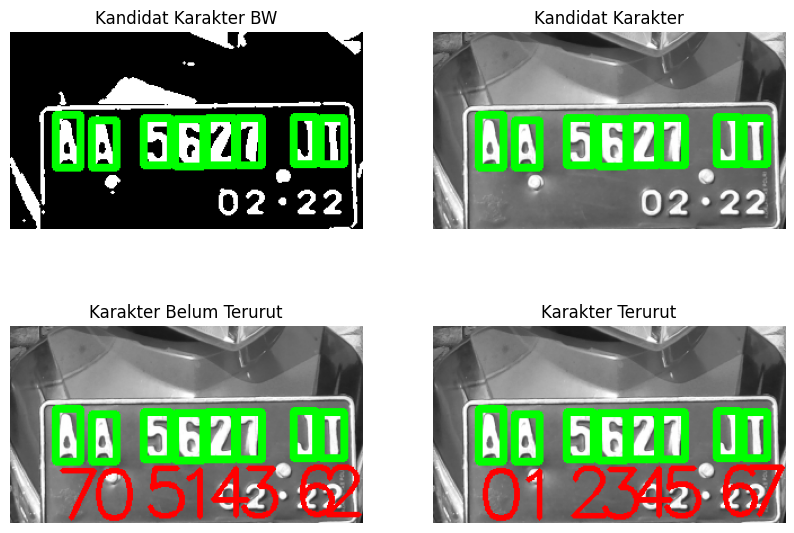

In [6]:
#----------------------------------------------------------------------------------------
# █▀▀ █▀▀ █▀▀▀ █▀▄▀█ █▀▀ █▀▀▄ ▀▀█▀▀ █▀▀█ █▀▀ ░▀░ 　 █░█ █▀▀█ █▀▀█ █▀▀█ █░█ ▀▀█▀▀ █▀▀ █▀▀█
# ▀▀█ █▀▀ █░▀█ █░▀░█ █▀▀ █░░█ ░░█░░ █▄▄█ ▀▀█ ▀█▀ 　 █▀▄ █▄▄█ █▄▄▀ █▄▄█ █▀▄ ░░█░░ █▀▀ █▄▄▀
# ▀▀▀ ▀▀▀ ▀▀▀▀ ▀░░░▀ ▀▀▀ ▀░░▀ ░░▀░░ ▀░░▀ ▀▀▀ ▀▀▀ 　 ▀░▀ ▀░░▀ ▀░▀▀ ▀░░▀ ▀░▀ ░░▀░░ ▀▀▀ ▀░▀▀
#----------------------------------------------------------------------------------------

# karakter yang akan disegmentasi adalah baris pertama yang berisi nilai unik setiap kendaraan

# konversi dari grayscale ke BW
(thresh, img_plate_bw) = cv.threshold(img_plate_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# hasil dari konversi BW tidak terlalu mulus,
# ada bagian-bagian kecil yang tidak diinginkan yang mungkin bisa mengganggu
# maka hilangkan area yang tidak diinginkan dengan operasi opening

# buat kernel dengan bentuk cross dan ukuran 3x3
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))

# cv.imshow("sebelum open", img_plate_bw)

# lakukan operasi opening dengan kernel di atas
img_plate_bw = cv.morphologyEx(img_plate_bw, cv.MORPH_OPEN, kernel) # apply morph open

# cv.imshow("sesudah open", img_plate_bw)

# Segmentasi karakter menggunakan contours
# dapatkan kontur dari plat nomor
contours_plate, hierarchy = cv.findContours(img_plate_bw, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# index contour yang berisi kandidat karakter
index_chars_candidate = [] #index

# index counter dari setiap contour di contours_plate
index_counter_contour_plate = 0 #idx

# duplikat dan ubah citra plat dari gray dan bw ke rgb untuk menampilkan kotak karakter
img_plate_rgb = cv.cvtColor(img_plate_gray,cv.COLOR_GRAY2BGR)
img_plate_bw_rgb = cv.cvtColor(img_plate_bw, cv.COLOR_GRAY2RGB)

# Mencari kandidat karakter
for contour_plate in contours_plate:

    # dapatkan lokasi x, y, nilai width, height dari setiap kontur plat
    x_char,y_char,w_char,h_char = cv.boundingRect(contour_plate)

    # Dapatkan kandidat karakter jika:
    #   tinggi kontur dalam rentang 40 - 60 piksel
    #   dan lebarnya lebih dari atau sama dengan 10 piksel
    if h_char >= 40 and h_char <= 60 and w_char >=10:

        # dapatkan index kandidat karakternya
        index_chars_candidate.append(index_counter_contour_plate)

        # gambar kotak untuk menandai kandidat karakter
        cv.rectangle(img_plate_rgb,(x_char,y_char),(x_char+w_char,y_char+h_char),(0,255,0),5)
        cv.rectangle(img_plate_bw_rgb,(x_char,y_char),(x_char+w_char,y_char+h_char),(0,255,0),5)

    index_counter_contour_plate += 1

# tampilkan kandidat karakter
# cv.imshow('Kandidat Karakter',img_plate_rgb)

if index_chars_candidate == []:

    # tampilkan peringatan apabila tidak ada kandidat karakter
    print('Karakter tidak tersegmentasi')
else:

    # Mendapatkan yang benar-benar karakter
    #   terkadang area lain yang bukan karakter ikut terpilih menjadi kandidat karakter
    #   untuk menghilangkannya bisa dicek apakah sebaris dengan karakter plat nomor atau tidak
    #
    # Caranya dengan Scoring:
    #   Bagian karakter plat nomor akan selalu sebaris,
    #       memiliki nilai y yang hampir sama atau tidak terlalu besar perbedaannya.
    #       Maka bandingkan nilai y dari setiap kandidat satu dengan kandidat lainnya.
    #   Jika perbedaannya tidak lebih dari 11 piksel maka tambahkan score 1 point ke kandidat tersebut.
    #       Kandidat yang benar-benar sebuah karakter akan memiliki nilai score yang sama dan tertinggi

    # Scoring

    # untuk menyimpan skor setiap karakter pada kandidat
    score_chars_candidate = np.zeros(len(index_chars_candidate))

    # untuk counter index karakter
    counter_index_chars_candidate = 0

    # bandingkan lokasi y setiap kandidat satu dengan kandidat lainnya
    for chars_candidateA in index_chars_candidate:

        # dapatkan nilai y dari kandidat A
        xA,yA,wA,hA = cv.boundingRect(contours_plate[chars_candidateA])
        for chars_candidateB in index_chars_candidate:

            # jika kandidat yang dibandikan sama maka lewati
            if chars_candidateA == chars_candidateB:
                continue
            else:
                # dapatkan nilai y dari kandidat B
                xB,yB,wB,hB = cv.boundingRect(contours_plate[chars_candidateB])

                # cari selisih nilai y kandidat A dan kandidat B
                y_difference = abs(yA - yB)

                # jika perbedaannya kurang dari 11 piksel
                if y_difference < 11:

                    # tambahkan nilai score pada kandidat tersebut
                    score_chars_candidate[counter_index_chars_candidate] = score_chars_candidate[counter_index_chars_candidate] + 1

        # lanjut ke kandidat lain
        counter_index_chars_candidate += 1

    print(score_chars_candidate)

    # untuk menyimpan karakter
    index_chars = []

    # counter karakter
    chars_counter = 0

    # dapatkan karakter, yaitu yang memiliki score tertinggi
    for score in score_chars_candidate:
        if score == max(score_chars_candidate):

            # simpan yang benar-benar karakter
            index_chars.append(index_chars_candidate[chars_counter])
        chars_counter += 1

    # Sampai disini sudah didapatkan karakternya
    #   sayangnya karena ini menggunakan contours,
    #   urutan karakter masih berdasarkan letak sumbu y, dari atas ke bawah,
    #   misal yang harusnya Z 1234 AB hasilnya malah 1 3Z24 BA.
    #   Hal ini akan menjadi masalah ketika nanti proses klasifikasi karakter.
    #   Maka mari disusun berdasarkan sumbu x, dari kiri ke kanan.

    # duplikat dan ubah ke rgb untuk menampilkan urutan karakter yang belum terurut
    img_plate_rgb2 = cv.cvtColor(img_plate_gray, cv.COLOR_GRAY2BGR)

    # tampilkan urutan karakter yang belum terurut
    for char in index_chars:
        x, y, w, h = cv.boundingRect(contours_plate[char])
        cv.rectangle(img_plate_rgb2,(x,y),(x+w,y+h),(0,255,0),5)
        cv.putText(img_plate_rgb2, str(index_chars.index(char)),(x, y + h + 50), cv.FONT_ITALIC, 2.0, (0,0,255), 3)

    # tampilkan karakter yang belum terurut
    # cv.imshow('Karakter Belum Terurut', img_plate_rgb2)

    # Mulai mengurutkan

    # untuk menyimpan koordinat x setiap karakter
    x_coors = []

    for char in index_chars:
        # dapatkan nilai x
        x, y, w, h = cv.boundingRect(contours_plate[char])

        # dapatkan nilai sumbu x
        x_coors.append(x)

    # urutkan sumbu x dari terkecil ke terbesar
    x_coors = sorted(x_coors)

    # untuk menyimpan karakter
    index_chars_sorted = []

    # urutkan karakternya berdasarkan koordinat x yang sudah diurutkan
    for x_coor in x_coors:
        for char in index_chars:

            # dapatkan nilai koordinat x karakter
            x, y, w, h = cv.boundingRect(contours_plate[char])

            # jika koordinat x terurut sama dengan koordinat x pada karakter
            if x_coors[x_coors.index(x_coor)] == x:

                # masukkan karakternya ke var baru agar mengurut dari kiri ke kanan
                index_chars_sorted.append(char)

    # duplikat dan ubah ke rgb untuk menampilkan yang benar-benar karakter
    img_plate_rgb3 = cv.cvtColor(img_plate_gray, cv.COLOR_GRAY2BGR)

    # Gambar kotak untuk menandai karakter yang terurut dan tambahkan teks urutannya
    for char_sorted in index_chars_sorted:

        # dapatkan nilai x, y, w, h dari karakter terurut
        x,y,w,h = cv.boundingRect(contours_plate[char_sorted])

        # gambar kotak yang menandai karakter terurut
        cv.rectangle(img_plate_rgb3,(x,y),(x+w,y+h),(0,255,0),5)

        # tambahkan teks urutan karakternya
        cv.putText(img_plate_rgb3, str(index_chars_sorted.index(char_sorted)),(x, y + h + 50), cv.FONT_ITALIC, 2.0, (0,0,255), 3)

    # tampilkan hasil pengurutan
    # cv.imshow('Karakter Terurut', img_plate_rgb3)

    # ==== Cek Segmentasi Karakter START ====
    # Bisa di comment/uncomment

    fig3 = plt.figure(figsize=(10, 7))
    row_fig = 2
    column_fig = 2

    fig3.add_subplot(row_fig, column_fig, 1)
    plt.imshow(img_plate_bw_rgb)
    plt.axis('off')
    plt.title("Kandidat Karakter BW")

    fig3.add_subplot(row_fig, column_fig, 2)
    plt.imshow(cv.cvtColor(img_plate_rgb, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Kandidat Karakter")

    fig3.add_subplot(row_fig, column_fig, 3)
    plt.imshow(cv.cvtColor(img_plate_rgb2, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Karakter Belum Terurut")

    fig3.add_subplot(row_fig, column_fig, 4)
    plt.imshow(cv.cvtColor(img_plate_rgb3, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Karakter Terurut")

    plt.show()

    # ==== Cek Segmentasi Karakter FINISH ====


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
T

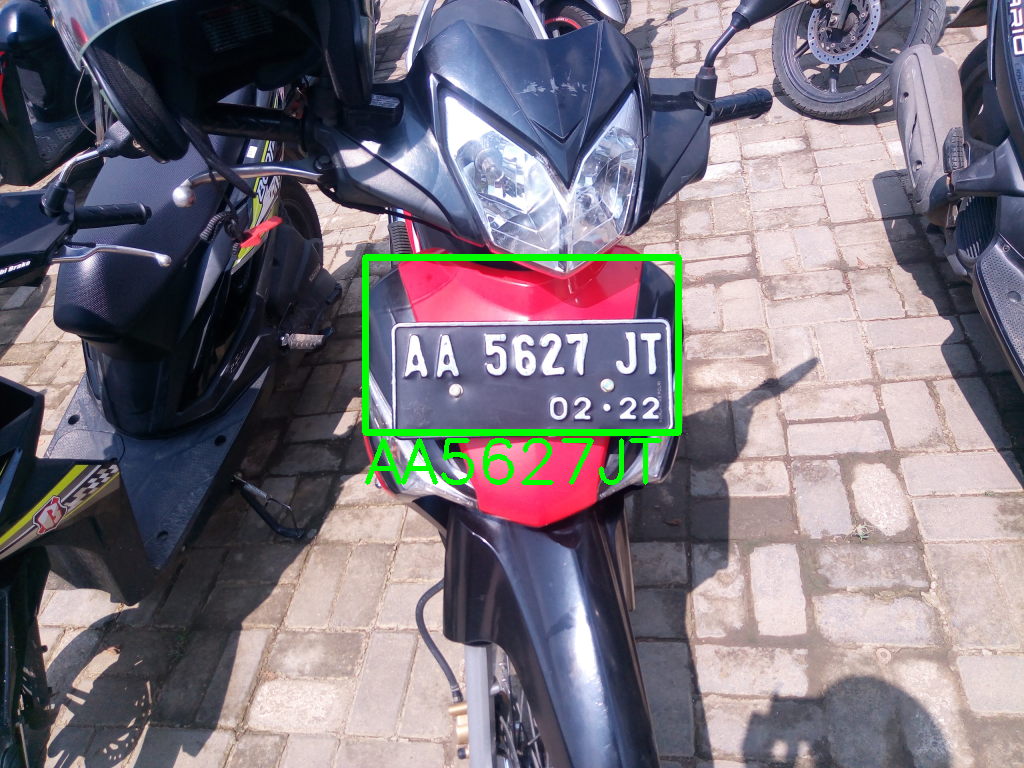

-1

In [7]:
#---------------------------------------------------------------------------------------
# █░█ █░░ █▀▀█ █▀▀ ░▀░ █▀▀ ░▀░ █░█ █▀▀█ █▀▀ ░▀░ 　 █░█ █▀▀█ █▀▀█ █▀▀█ █░█ ▀▀█▀▀ █▀▀ █▀▀█
# █▀▄ █░░ █▄▄█ ▀▀█ ▀█▀ █▀▀ ▀█▀ █▀▄ █▄▄█ ▀▀█ ▀█▀ 　 █▀▄ █▄▄█ █▄▄▀ █▄▄█ █▀▄ ░░█░░ █▀▀ █▄▄▀
# ▀░▀ ▀▀▀ ▀░░▀ ▀▀▀ ▀▀▀ ▀░░ ▀▀▀ ▀░▀ ▀░░▀ ▀▀▀ ▀▀▀ 　 ▀░▀ ▀░░▀ ▀░▀▀ ▀░░▀ ▀░▀ ░░▀░░ ▀▀▀ ▀░▀▀
#---------------------------------------------------------------------------------------

# untuk mengklasifikasi karakter, saya menggunakan tutorial:
# https://www.tensorflow.org/tutorials/images/classification
# hasil klasifikasi akan tersimpan di var plate_number

# Check if index_chars_candidate is not empty before proceeding
if index_chars_candidate:
    # tinggi dan lebar citra untuk test
    img_height = 40
    img_width = 40

    # klas karakter
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

    # load model yang sudah terlatih
    model = keras.models.load_model('/content/model_plat_indonesia.keras')

    # untuk menyimpan string karakter
    num_plate = []

    for char_sorted in index_chars_sorted:
        x,y,w,h = cv.boundingRect(contours_plate[char_sorted])

        # potong citra karakter
        char_crop = cv.cvtColor(img_plate_bw[y:y+h,x:x+w], cv.COLOR_GRAY2BGR)

        # resize citra karakternya
        char_crop = cv.resize(char_crop, (img_width, img_height))

        # preprocessing citra ke numpy array
        img_array = keras.preprocessing.image.img_to_array(char_crop)

        # agar shape menjadi [1, h, w, channels]
        img_array = tf.expand_dims(img_array, 0)

        # buat prediksi
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        num_plate.append(class_names[np.argmax(score)])
        print(class_names[np.argmax(score)], end='')

    # Gabungkan string pada list
    plate_number = ''
    for a in num_plate:
        plate_number += a

    # Hasil deteksi dan pembacaan
    cv.putText(img_show_plate, plate_number,(x_plate, y_plate + h_plate + 50), cv.FONT_ITALIC, 2.0, (0,255,0), 3)
    # Use cv2_imshow instead of cv.imshow
    cv2_imshow(img_show_plate)

cv.waitKey(0)
